### ESA CCI data example for a single file

This notebook describes how to access and visualize the data of one tile the transect of the ESA Vegetation CCI data.

To run this notebook, you need to follow this one-time installation steps: discover the `python` executable that is used to run this notebook, for installing the python extensions `wget` and `netCDF4`

In [1]:
import sys
from platform import python_version
print(sys.executable)
print(python_version())

/usr/bin/python
3.8.10


Use the discovered `python` executable to install the extensions (uncomment and edit where appropriate). Only one time needed.

In [2]:
#!/usr/bin/python -m pip install --upgrade pip
#!/usr/bin/python -m pip install wget
#!/usr/bin/python -m pip install netCDF4

The above steps are only required the first time the notebook is executed.
The regular execution starts below, with the imports.

In [11]:
import wget
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

#### User guide for Vegation CCI+ data CRDP-1 dataset
You can find documentation here about the data set here:
https://data.ceda.ac.uk/neodc/esacci/vegetation_parameters/docs/L3S/vp_products/v1.0
https://climate.esa.int/media/documents/VP-CCI_D4.2_PUG_V1.2.pdf
The dataset includes time series at selected sites, and data in tiles. The tiles dataset does not have global coverage (at least in dataset CRDP-1, a future dataset (CRDP-3), will have global coverage). You can find the tiles that are included in the map below. The remainder of this instruction is about using the tile data.

Define a location and a time for downloading a single data file. The ESA CCI data is organized in tiles. The image below (from the manual) indicates the available tiles (enclosed in red). Combining the label on the x-axis and the label on the y-axis, a tile-identifier can be composed.

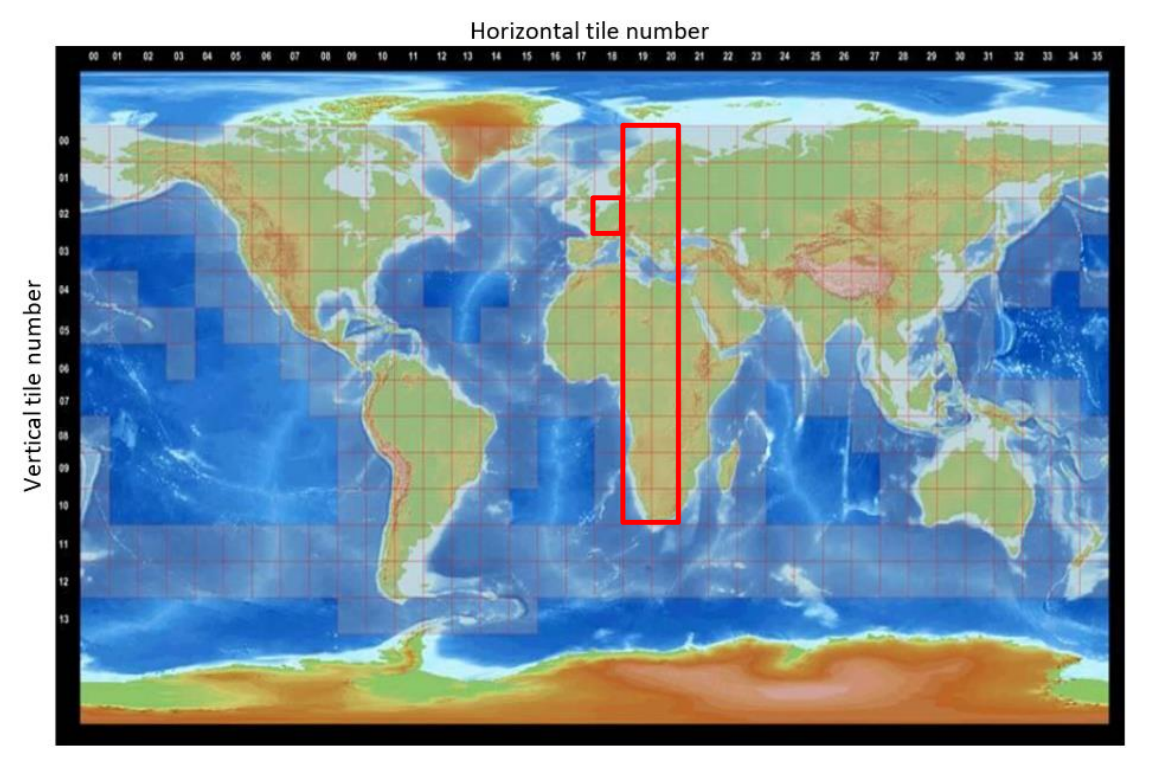

Tiling reference (from Wolters et al., 2023). The red outlined area indicated the tiles that are delivered for CRDP-1.

In [5]:
# The tile covering Netherlands, Belgium, Luxembourg, and part of Switzerland, France and Germany: x-label is 18, tile y-label is 02
tile = 'X18Y02'

Data availability: every 5 days, counting from January 1.

The first date where data is available is 2000-01-01, and the last date is 2020-06-29.

The code below "rounds" the date that is requested by the user to the closest date where data is available (the closest multiple of 5 days is computed).

In [12]:
d = datetime(2019,7,10)
print('Requested date:', d.strftime('%Y'), d.strftime('%m'), d.strftime('%d'))

# Find closest date that is a multiple of 5 days starting at January 1

julian_day = d.timetuple().tm_yday
mul_5_julian_day = 1 + 5 * int((julian_day - 1) / 5)
closest_mul_5_julian_day = mul_5_julian_day if julian_day - mul_5_julian_day < 3 else mul_5_julian_day + 5
delta = closest_mul_5_julian_day - julian_day
delta = timedelta(days = delta)
d = d + delta
year = d.strftime('%Y')
month = d.strftime('%m')
day = d.strftime('%d')
print('Closest date:', year, month, day)

Requested date: 2019 07 10
Closest date: 2019 07 10


Concatenate the tile identifier and the date, to compose a url for downloading a data file.

In [13]:
base_url = 'https://dap.ceda.ac.uk/neodc/esacci/vegetation_parameters/data/L3S/vp_products/v1.0/transect'
filename = 'ESACCI-VEGETATION-L3S-VP_PRODUCTS-MERGED-tile_' + tile + '-' + year + month + day + '-fv1.0.nc'
url = base_url + '/' + year + '/' + tile + '/' + filename
print(url)

https://dap.ceda.ac.uk/neodc/esacci/vegetation_parameters/data/L3S/vp_products/v1.0/transect/2019/X18Y02/ESACCI-VEGETATION-L3S-VP_PRODUCTS-MERGED-tile_X18Y02-20190710-fv1.0.nc


Download the data file, in netCDF format.

In [14]:
wget.download(url)

'ESACCI-VEGETATION-L3S-VP_PRODUCTS-MERGED-tile_X18Y02-20190710-fv1.0 (2).nc'

Print the contents of the netCDF file (dimension names and variable names)

In [15]:
nc_fid = Dataset(filename)
dimensions = nc_fid.dimensions
variables = nc_fid.variables
print(list(dimensions.keys()))
print(list(variables.keys()))

['time', 'lat', 'lon', 'nbnds']
['lon_bnds', 'lat_bnds', 'time_bnds', 'crs', 'lat', 'lon', 'time', 'LAI', 'LAI_ERR', 'fAPAR', 'fAPAR_ERR', 'LAI_fAPAR_correl', 'n_bands_used', 'p_chisquare', 'invcode']


Extract some of the variables. The ones that will actually be used in this notebook are `LAI`, `invcode` and `LAI_ERR`.

Note: `invcode` (inversion code) is a 10-bit diagnostic mask (stored as 32-bits, for future use). It represents the inversion code of the retrieval algorithm and contains various diagnostics.
Bits 3,7,10-31 are currently not used.

* Bit Value Flag Meaning
* 0 1 NOT_PROCESSED Pixel not processed (sea point or missing data)
* 1 2 OPTIERR_TOO_MANY_ITER Inversion stopped at iteration limit
* 2 4 OPTIERR_LNSRCH Inversion stopped for numerical reasons
* 4 16 XHESSERR_NOTSYM The computed Hessian matrix is not symmetric, and uncertainties and correlations cannot be computed.
* 5 32 XHESSERR_INVERSION The computed Hessian matrix cannot be inverted, and uncertainties and correlations cannot be computed.
* 6 64 XHESSERR_NOTPOSDEF The computed Hessian matrix is not positive definite (e.g. if no cost function minimum was reached), and uncertainties and correlations cannot be computed.
* 8 256 RETR_UNTRUSTED The retrieval is not trusted, because any of the previous bits with “ERR” in their name are raised, or the chi-square-criterion is violated.
* 9 512 RETR_LOW_QUALITY The retrieval matches one or more criteria defined for low quality (see text for explanation)

It is recommended to use the RETR_UNTRUSTED flag. The flag RETR_LOW_QUALITY filters out many of the outliers in the dataset, but also removes good retrievals (see section 3.6 in VPCCI_D4.1_PVIR for detailed analysis).

In [16]:
lat = variables['lat'][:]
lon = variables['lon'][:]
LAI = variables['LAI'][:][0]
invcode = variables['invcode'][:][0]
LAI_ERR = variables['LAI_ERR'][:][0]
p_chisquare = variables['p_chisquare'][:][0]
n_bands_used = variables['n_bands_used'][:][0]

Print the 1-dimensional arrays with latitudes and longitudes.

Note that the latitudes range from high to low, indicating that the image is stored line-by-line from top to bottom.

In [17]:
print(lat)
print(lon)

[55.       54.99107  54.982143 ... 45.026787 45.017857 45.00893 ]
[0.0000000e+00 8.9285718e-03 1.7857144e-02 ... 9.9732141e+00 9.9821424e+00
 9.9910717e+00]


Plot the Leaf Area Index, to get an appreciation in a figure.

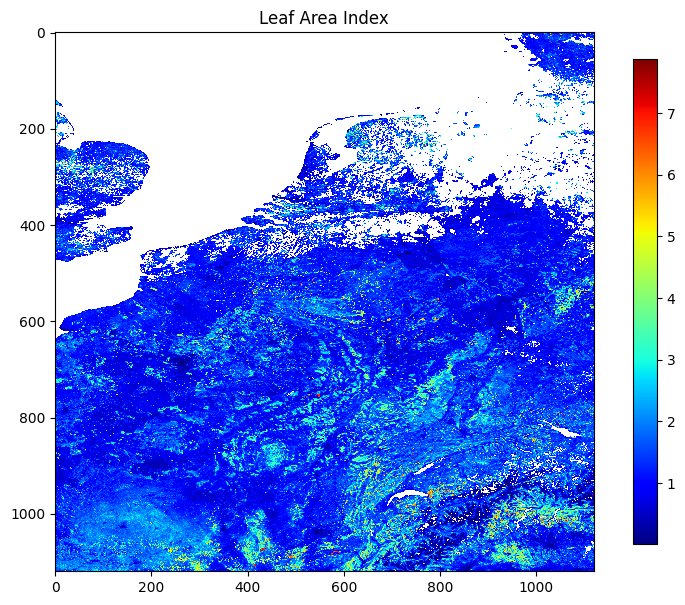

In [18]:
fig = plt.figure(figsize=(10, 7))
plt.imshow(LAI, interpolation='none', cmap='jet')
plt.colorbar(shrink=0.9)
t = plt.title('Leaf Area Index')

Use the `invcode` mask, to eliminate unreliable pixels from the LAI image. Once for the `untrusted` flag, and once for the `low_quality` flag.

In [19]:
RETR_UNTRUSTED = 256 # bit 8 of the 10-bits mask 'invcode'
# The retrieval is not trusted, because any of the bits with “ERR” in their name are raised, or the chi-square-criterion is violated

RETR_LOW_QUALITY = 512 # bit 9 of the 10-bits mask 'invcode'
# The retrieval matches one or more criteria defined for low quality (see text in https://climate.esa.int/media/documents/VP-CCI_D4.2_PUG_V1.2.pdf for explanation)
# It is recommended to use the RETR_UNTRUSTED flag. The flag RETR_LOW_QUALITY filters out many of the outliers in the dataset, but also removes good retrievals (see section 3.6 in VPCCI_D4.1_PVIR for detailed analysis).

In [20]:
LAI_TRUSTED = np.ma.masked_where(invcode & RETR_UNTRUSTED == RETR_UNTRUSTED, LAI)

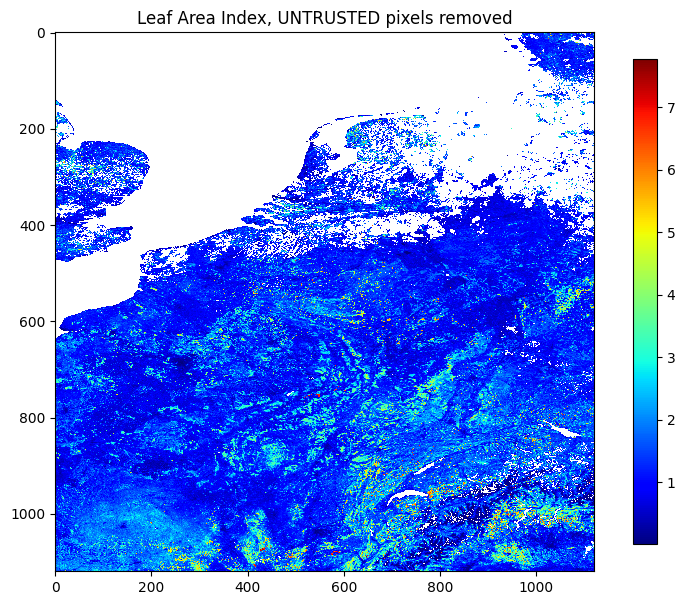

In [21]:
fig = plt.figure(figsize=(10, 7))
plt.imshow(LAI_TRUSTED, interpolation='none', cmap='jet')
plt.colorbar(shrink=0.9)
t = plt.title('Leaf Area Index, UNTRUSTED pixels removed')

In [22]:
LAI_HIGH_QUALITY = np.ma.masked_where(invcode & RETR_LOW_QUALITY == RETR_LOW_QUALITY, LAI)

Note that the image is reduced significantly when eliminating the LOW_QUALITY pixels.

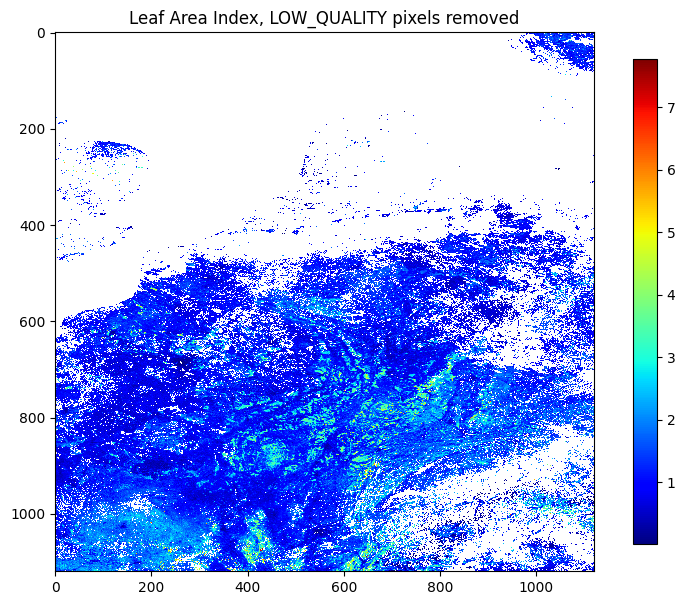

In [23]:
fig = plt.figure(figsize=(10, 7))
plt.imshow(LAI_HIGH_QUALITY, interpolation='none', cmap='jet')
plt.colorbar(shrink=0.9)
t = plt.title('Leaf Area Index, LOW_QUALITY pixels removed')

For some applications, it is useful to spatially aggregate the data. In the example below, a new image is constructed based on a given pixel size (`new_pixel_size`) using the `mean` formula over the `LAI` layer. There are alternative ways to do this. In the example the spatial mean is calculated with uncertainty. As an alternative, the LAI can be computed weighted by the relative uncertainty. Some tests are needed to verify whether this secibd approach does not favour low values of LAI.

In [24]:
new_pixel_size = 0.1
x = len(lon)
y = len(lat)
print('Current x-size', x)
print('Current y-size', y)
current_pixel_size_x = (lon[-1]-lon[0]) / (x - 1)
current_pixel_size_y = (lat[0]-lat[-1]) / (y - 1)
print('Current pixel size, x-direction', current_pixel_size_x)
print('Current pixel size, y-direction', current_pixel_size_y)
print('New pixel size', new_pixel_size)
x_new = round(current_pixel_size_x * x / new_pixel_size)
y_new = round(current_pixel_size_y * y / new_pixel_size)
x_tile = int(x / x_new)
y_tile = int(y / y_new)
x_new = int(x / x_tile)
y_new = int(y / y_tile)
print('New x-size', x_new)
print('New y-size', y_new)
print('Tile x-size', x_tile)
print('Tile y-size', y_tile)

Current x-size 1120
Current y-size 1120
Current pixel size, x-direction 0.008928571672073105
Current pixel size, y-direction 0.008928569967561369
New pixel size 0.1
New x-size 101
New y-size 101
Tile x-size 11
Tile y-size 11


In [48]:
# Create and fill aggregated array, using the pixel data from LAI_TRUSTED as the source
LAI_aggregated = np.empty((y_new, x_new))
LAI_aggregated_unc = np.empty((y_new, x_new))

for x in range(0, x_new):
    x1 = x*x_tile
    x2 = (x+1)*x_tile
    for y in range(0, y_new):
        y1 = y*y_tile
        y2 = (y+1)*y_tile
        # [y1:y2,x1:x2] is now the x_tile x y_tile moving window to compute the "mean" (in our example 11x11 pixels)
        # there are different ways to calculate a spatial mean. The first option just calculates an average irrespective of the uncertainty of the data of the individual pixels
        # method 1: (commented out preferred method:)
        LAImean = np.nansum(LAI_TRUSTED[y1:y2,x1:x2])/((y2-y1)*(x2-x1))
        LAIunc = np.sqrt(np.nansum(np.power(LAI_ERR[y1:y2,x1:x2],2))/((y2-y1)*(x2-x1)))
        LAIunc = np.ma.filled(LAIunc, np.nan)
        LAI_aggregated_unc[y,x] = LAIunc
        
        # the second method uses the relative uncertainty (uncertainty over the value) to weight the observations. Using the absolute uncertainty to weight the observation will bias larger values, but using the relative uncertainty may bias smaller values
        # method 2:
        # LAImean = np.nansum(LAI_TRUSTED[y1:y2,x1:x2]/np.power((LAI_ERR[y1:y2,x1:x2]/LAI[y1:y2,x1:x2]) ,2))/np.nansum(1.0/np.power((LAI_ERR[y1:y2,x1:x2]/LAI[y1:y2,x1:x2]),2))

        LAImean = np.ma.filled(LAImean, np.nan)
        LAI_aggregated[y,x] = LAImean
        
        


Make a plot of the spatially aggregated data

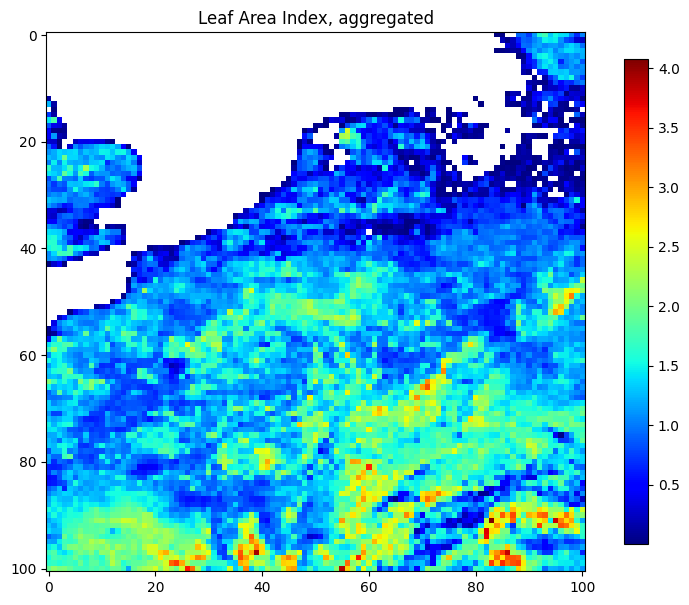

In [49]:
fig = plt.figure(figsize=(10, 7))
plt.imshow(LAI_aggregated, interpolation='none', cmap='jet')
plt.colorbar(shrink=0.9)
t = plt.title('Leaf Area Index, aggregated')